Interactively figure out MGRS tiles and track numbers

In [191]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [192]:
yaml_file = 'events/mai_mahiu_flood_and_landslides_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'mai_mahiu_flood_and_landslides_2024',
 'bounds': [36.56645031, -1.32126631, 37.13272135, -0.92335618],
 'event_date': '2024-04-29',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7, 109],
 'mgrs_tiles': ['37MBU'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange - Pléiades image',
 'links': ['https://data.humdata.org/dataset/landslide-mudslide-impact-in-mai-mahiu-and-kijabe-towns-kenya-as-of-1-may-2024',
  'https://eos.org/thelandslideblog/mai-mahiu']}

# Read Geojson

In [193]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [194]:
# df_event.plot()

In [195]:
df_event.head()

,name,date,source_id,geometry
0,mai_mahiu_flood_and_landslides_2024,2024-04-29,UNOSAT via humanitarian data exchange - Pléiad...,"MULTIPOLYGON (((36.57978 -0.98891, 36.57977 -0..."
1,mai_mahiu_flood_and_landslides_2024,2024-04-29,UNOSAT via humanitarian data exchange - Pléiad...,"MULTIPOLYGON (((37.06500 -1.31769, 37.06500 -1..."


In [196]:
df_event.total_bounds

array([36.56645031, -1.32126631, 37.13272135, -0.92335618])

# Create Spatial AOI

In [197]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [198]:
bounds = aoi.bounds
bounds

(36.566450314000065,
 -1.3212663069999167,
 37.132721349000064,
 -0.9233561819999047)

# Find MGRS tiles and Explore

In [199]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
2,36MZD,32736,"MULTIPOLYGON(((799980 9900040,799980 9790240,9...","MULTIPOLYGON (((35.69518 -0.90336, 35.69631 -1..."
3,36MZE,32736,"MULTIPOLYGON(((799980 10000000,799980 9890200,...","MULTIPOLYGON (((35.69484 0.00000, 35.69525 -0...."
4,37MBU,32737,"MULTIPOLYGON(((199980 9900040,199980 9790240,3...","MULTIPOLYGON (((36.30446 -0.90336, 36.30333 -1..."
5,37MBV,32737,"MULTIPOLYGON(((199980 10000000,199980 9890200,...","MULTIPOLYGON (((36.30480 0.00000, 36.30440 -0...."


In [200]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [201]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['37MBU']

In [202]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

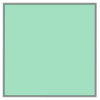

In [203]:
search_geo

# Explore Availability of RTC Data

In [204]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [205]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

163

In [206]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

90

In [207]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [210]:
df_rtc_resp_pre_e.pathNumber.unique()

array([130,  57])

In [211]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([30, 51])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [212]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((36.21075 -1.06800, 36.92086 -0.91394...",-0.897474,36.548217,2024-06-23T15:56:53Z,OPERA_L2_RTC-S1_T130-279218-IW3_20240623T15565...,ASCENDING,130,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-06-23T15:56:50Z,...,None,IW3,OPERA_L2_RTC-S1_T130-279218-IW3_20240623T15565...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((36.24452 -1.23495, 36.95376 -1.08089...",-1.074443,36.582405,2024-06-23T15:56:50Z,OPERA_L2_RTC-S1_T130-279217-IW3_20240623T15564...,ASCENDING,130,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-06-23T15:56:47Z,...,None,IW3,OPERA_L2_RTC-S1_T130-279217-IW3_20240623T15564...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((36.28272 -1.40068, 36.98922 -1.24704...",-1.240850,36.617484,2024-06-23T15:56:48Z,OPERA_L2_RTC-S1_T130-279216-IW3_20240623T15564...,ASCENDING,130,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-06-23T15:56:44Z,...,None,IW3,OPERA_L2_RTC-S1_T130-279216-IW3_20240623T15564...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((35.52667 -1.62527, 36.32570 -1.45170...",-1.455074,35.908572,2024-06-23T15:56:47Z,OPERA_L2_RTC-S1_T130-279216-IW2_20240623T15564...,ASCENDING,130,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-06-23T15:56:44Z,...,None,IW2,OPERA_L2_RTC-S1_T130-279216-IW2_20240623T15564...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((36.30947 -1.56880, 37.02461 -1.41307...",-1.407583,36.651465,2024-06-23T15:56:45Z,OPERA_L2_RTC-S1_T130-279215-IW3_20240623T15564...,ASCENDING,130,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-06-23T15:56:42Z,...,None,IW3,OPERA_L2_RTC-S1_T130-279215-IW3_20240623T15564...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
